<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

In [2]:
# loading csv
business = pd.read_csv('/Users/KerryChowChow/DSI-SF-3-kelly/datasets/yelp_arizona_data/businesses_small_parsed.csv')
reviews = pd.read_csv('/Users/KerryChowChow/DSI-SF-3-kelly/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
users = pd.read_csv('/Users/KerryChowChow/DSI-SF-3-kelly/datasets/yelp_arizona_data/users_small_parsed.csv')
checkin = pd.read_csv('/Users/KerryChowChow/DSI-SF-3-kelly/datasets/yelp_arizona_data/checkins_small_parsed.csv')
tips = pd.read_csv('/Users/KerryChowChow/DSI-SF-3-kelly/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

### Kelly: only look at the business dataset for this problem with a hypothesis that reviews say less about city profiles than businesses types. Going to test this by running a quick statsmodel.

In [307]:
business.tail()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,new_categories
152827,nda3uTUCzgx4y4OYTYmlzA,Killer Shrimp,54,Las Vegas,3.5,"['Nightlife', 'Seafood', 'Bars', 'Restaurants']",36.067129,-115.178148,['Southeast'],attributes.Ambience.upscale,False,Bars
152828,6Nt37fvCzw0CkoVko_ejww,Raising Cane's,9,Las Vegas,4.5,"['American (Traditional)', 'Fast Food', 'Chick...",36.100513,-115.186880,[],attributes.Ambience.upscale,False,Fast Food
152829,bbd0caaIBMJH6tHDjevQKg,Salt 'N Pepper Southern Comfort Bar and Grill,29,Las Vegas,3.0,"['Bars', 'American (Traditional)', 'Southern',...",36.166727,-115.286842,['Westside'],attributes.Ambience.upscale,False,Bars
152830,qjRBMRCUlUx8Ofe9tiSlTA,CoR Tapas & Wine,21,Phoenix,4.0,"['Tapas/Small Plates', 'Bars', 'Nightlife', 'W...",33.502143,-112.056506,[],attributes.Ambience.upscale,False,Bars
152831,dh1zBLeeN61VEemOEkbYQQ,Fuku Burger,25,Las Vegas,4.0,"['Burgers', 'Restaurants']",36.126606,-115.225239,['Chinatown'],attributes.Ambience.upscale,False,Burgers


In [299]:
business.value.unique()

array(['False', 'True', '09:00', '11:00', '07:00', '09:30', '16:00',
       '10:00', '05:00', '17:00', '21:00', '10:30', '06:00', '06:30',
       '08:00', '00:00', '15:00', '15:30', '11:30', '04:00', '14:00',
       '01:00', '12:00', '05:30', '04:30', '07:30', '08:30', '18:00',
       '17:30', '22:00', '20:00', '14:30', '22:30', '13:00', '19:30',
       '16:30', '03:00', '19:00', '23:00', '20:30', '18:30', '05:45',
       '12:30', '00:30', '21:30', '23:30', 'full_bar', 'none',
       'beer_and_wine', 'no', 'yes_free', 'yes_corkage', '1.0', '2.0',
       '3.0', '4.0', '02:00', '01:30', '02:30', '13:30', '19:15', '01:20',
       '01:45', '03:30', '20:15', '23:59', '01:15', '11:45', '22:15',
       '15:45', '15:15', '21plus', '18plus', 'allages', 'free', 'paid',
       '16:45', '19:45', '03:45', 'very_loud', 'average', 'loud', 'quiet',
       'outdoor', 'yes', 'casual', 'dressy', 'formal'], dtype=object)

In [328]:
pd.DataFrame(business.groupby(['name','variable', 'value']).size())

0
name    variable                          value       
1 OAK   attributes.Accepts Credit Cards   True       1
        attributes.Ages Allowed           21plus     1
        attributes.Alcohol                full_bar   1
        attributes.Ambience.casual        False      1
        attributes.Ambience.classy        False      1
        attributes.Ambience.divey         False      1
        attributes.Ambience.hipster       False      1
        attributes.Ambience.intimate      False      1
        attributes.Ambience.romantic      False      1
        attributes.Ambience.touristy      False      1
        attributes.Ambience.trendy        True       1
        attributes.Ambience.upscale       False      1
        attributes.Coat Check             True       1
        attributes.Good For Dancing       True       1
        attributes.Good For Groups        True       1
        attributes.Happy Hour             False      1
        attributes.Has TV                 False      1
        attributes.Music.background_music False      1
        attributes.Music.dj               True       1
        attributes.Music.jukebox          False      1
        attributes.Music.karaoke          False      1
        attributes.Music.live             False      1
        attributes.Music.video            False      1
        attributes.Noise Level            very_loud  1
        attributes.Outdoor Seating        False      1
        attributes.Parking.garage         True       1
        attributes.Parking.lot            False      1
        attributes.Parking.street         False      1
        attributes.Parking.valet          True       1
        attributes.Parking.validated      False      1
...                                                 ..
twenty6 attributes.Has TV                 True       1
        attributes.Music.dj               False      1
        attributes.Noise Level            average    1
        attributes.Outdoor Seating        True       1
        attributes.Parking.garage         False      1
        attributes.Parking.lot            True       1
        attributes.Parking.street         False      1
        attributes.Parking.valet          True       1
        attributes.Parking.validated      False      1
        attributes.Price Range            2.0        1
        attributes.Take-out               True       1
        attributes.Takes Reservations     False      1
        attributes.Waiter Service         True       1
        attributes.Wheelchair Accessible  True       1
        attributes.Wi-Fi                  free       1
        hours.Friday.close                00:00      1
        hours.Friday.open                 11:00      1
        hours.Monday.close                00:00      1
        hours.Monday.open                 11:00      1
        hours.Saturday.close              00:00      1
        hours.Saturday.open               11:00      1
        hours.Sunday.close                00:00      1
        hours.Sunday.open                 11:00      1
        hours.Thursday.close              00:00      1
        hours.Thursday.open               11:00      1
        hours.Tuesday.close               00:00      1
        hours.Tuesday.open                11:00      1
        hours.Wednesday.close             00:00      1
        hours.Wednesday.open              11:00      1
        open                              True       1

[106665 rows x 1 columns]

##### We spent some time looking at the variable (it includes a mix of ambiance and hours) and value columns under business dataset. We decided to leave them first due to the complexity of their column values. After running a model and if the score needs to be improved, we’ll come back to do more feature engineering.

### -----> UPDATE: we sorted by name first then by variables and values , then find out that a business contains multiple rows based on the number of variables it has. SO cleaning the 'variable' and 'value' columns are important

In [ ]:
## breaking the variable column down to attributes and hours
## if the value in the same columns is True or False statement, get_dummies
##

In [3]:
# look at # of rows start with attributes and # of rows start with hours
import re
business[business['variable'].str.contains(r'attributes')].count()
#we get 114926 rows that contain 'attributes'

business_id      114926
name             114926
review_count     114926
city             114926
stars            114926
categories       114926
latitude         114926
longitude        114926
neighborhoods    114926
variable         114926
value            114926
dtype: int64

In [68]:
## creating a new attribute column
#attribute_df = business[business['variable'].str.contains(r'attributes')]


## After a bunch of trials and errors, we figured that we can use pivot to convert variable and values back

In [215]:
## getting a list of unique variable names, they will be converted back to columns later
var_uni = business['variable'].unique()
var_uni

array(['attributes.Ambience.divey',
       'attributes.Dietary Restrictions.vegan', 'attributes.Happy Hour',
       'hours.Thursday.open', 'attributes.Order at Counter',
       'attributes.BYOB', 'hours.Friday.open',
       'attributes.Good For.latenight', 'attributes.Outdoor Seating',
       'attributes.Alcohol', 'attributes.Ambience.classy',
       'attributes.By Appointment Only', 'attributes.Parking.lot',
       'attributes.Ambience.touristy', 'attributes.Corkage',
       'hours.Tuesday.open', 'attributes.Good For.brunch',
       'attributes.Waiter Service', 'hours.Monday.open',
       'attributes.Parking.street', 'attributes.Ambience.hipster',
       'attributes.BYOB/Corkage', 'attributes.Music.live',
       'attributes.Dietary Restrictions.dairy-free',
       'attributes.Music.background_music', 'attributes.Price Range',
       'attributes.Good For.breakfast', 'attributes.Parking.garage',
       'attributes.Music.karaoke', 'attributes.Good For Dancing',
       'attributes.Accepts

In [4]:
# converting all the string values in 'value' column into numerica variables. Use apply()
value_list = business['value'].unique()
value_list

array(['False', 'True', '09:00', '11:00', '07:00', '09:30', '16:00',
       '10:00', '05:00', '17:00', '21:00', '10:30', '06:00', '06:30',
       '08:00', '00:00', '15:00', '15:30', '11:30', '04:00', '14:00',
       '01:00', '12:00', '05:30', '04:30', '07:30', '08:30', '18:00',
       '17:30', '22:00', '20:00', '14:30', '22:30', '13:00', '19:30',
       '16:30', '03:00', '19:00', '23:00', '20:30', '18:30', '05:45',
       '12:30', '00:30', '21:30', '23:30', 'full_bar', 'none',
       'beer_and_wine', 'no', 'yes_free', 'yes_corkage', '1.0', '2.0',
       '3.0', '4.0', '02:00', '01:30', '02:30', '13:30', '19:15', '01:20',
       '01:45', '03:30', '20:15', '23:59', '01:15', '11:45', '22:15',
       '15:45', '15:15', '21plus', '18plus', 'allages', 'free', 'paid',
       '16:45', '19:45', '03:45', 'very_loud', 'average', 'loud', 'quiet',
       'outdoor', 'yes', 'casual', 'dressy', 'formal'], dtype=object)

In [121]:
business.groupby([business['variable']== 'attributes.Alcohol'])['value'].unique()

variable
False    [False, True, 09:00, 11:00, 07:00, 09:30, 16:0...
True                       [full_bar, none, beer_and_wine]
Name: value, dtype: object

In [123]:
#business[business['value']== 'yes_corkage']
business.groupby([business['variable']== 'attributes.BYOB/Corkage'])['value'].unique()

variable
False    [False, True, 09:00, 11:00, 07:00, 09:30, 16:0...
True                           [no, yes_free, yes_corkage]
Name: value, dtype: object

In [174]:
business[business['variable'] == 'attributes.Smoking']['value'].unique()

array(['outdoor', 'no', 'yes'], dtype=object)

In [180]:
business[(business['value']=='formal')]['new_categories'].unique()
#going to mark formal and casual as one category

array(['Fast Food', 'Burgers'], dtype=object)

In [5]:
# check time

import time

def isTimeFormat(input):
    try:
        time.strptime(input, '%H:%M')
        return True
    except ValueError:
        return False


isTimeFormat('6:00')

True

In [6]:
#t = ['09:00', '11:00', '07:00', '09:30']
t = '16:00'
t = re.findall(r'(..):',t)
int(t[0])

## testing to turn all the time value into integers

16

In [219]:
n = re.findall(r'(.).','3.0')
int(n[0])

3

In [7]:
def value_sort(x):
    if x == 'True':
        return 1
    elif x == 'False':
        return 0
    elif x == 'full_bar' or x == 'beer_and_wine' or x == 'yes_corkage' or x == 'yes_free' or x =='yes' or x =='dressy' or x=='outdoor' or x=='very_loud' or x=='loud' or x=='paid' or x=='21plus' or x=='18plus':
        return 1
    elif x == 'none' or x == 'no' or x=='formal' or x=='casual' or x=='allages' or x=='free' or x=='average' or x=='quiet':
        return 0
    elif isTimeFormat(x) == True:
        x1 = re.findall(r'(..):',x)
        x1 = int(x1[0])
        return x1
    else:
        return float(x)
    


    
    
    

In [209]:
for v in value_list:
    print value_sort(v)


0
1
9
11
7
9
16
10
5
17
21
10
6
6
8
0
15
15
11
4
14
1
12
5
4
7
8
18
17
22
20
14
22
13
19
16
3
19
23
20
18
5
12
0
21
23
1
0
1
0
1
1
1.0
2.0
3.0
4.0
2
1
2
13
19
1
1
3
20
23
1
11
22
15
15
1
1
0
0
1
16
19
3
1
0
1
0
1
1
0
1
0


## below, I'm converting all the values under 'value' column into numeric variables

/''full_bar' = 1
/, 'none', = 0
/'beer_and_wine'= 1
, 'no', 'yes_free', 'yes_corkage'=1

, '1.0', '2.0',
'3.0', '4.0', 

/'21plus' =1 , '18plus'= 1, 'allages' =0

/, 'free'=0, 'paid'=1,
/'very_loud'=1, 'average' =0 , 'loud' =1, 'quiet'=0,
/'outdoor'=1
/'casual' =0 , 'dressy' =1, 'formal'=0

], dtype=object)'

In [8]:
business['new_value'] = business['value'].apply(value_sort)

## Useing Pivot to convert long to wide

In [9]:
business_wide = pd.pivot_table(business,  columns = ['variable'], values = ['new_value'],index= ['business_id', 'name'], aggfunc = int).reset_index()

In [229]:
business_wide.head()

business_id         name                       new_value  \
variable                                      attributes.Accepts Credit Cards   
0         --jFTZmywe7StuZ2hEjxyA       Subway                             1.0   
1         -0HGqwlfw3I8nkJyMHxAsQ   McDonald's                             1.0   
2         -0VK5Z1BfUHUYq4PoBYNLw       T Spot                             1.0   
3         -0bUDim5OGuv8R0Qqq6J4A         IHOP                             1.0   
4         -1bOb2izeJBZjHC7NWxiPA  First Watch                             1.0   

                                                               \
variable attributes.Accepts Insurance attributes.Ages Allowed   
0                                 NaN                     NaN   
1                                 NaN                     NaN   
2                                 NaN                     NaN   
3                                 NaN                     NaN   
4                                 NaN                     NaN   

                                                        \
variable attributes.Alcohol attributes.Ambience.casual   
0                       0.0                        NaN   
1                       0.0                        NaN   
2                       1.0                        1.0   
3                       NaN                        NaN   
4                       0.0                        1.0   

                                                               \
variable attributes.Ambience.classy attributes.Ambience.divey   
0                               NaN                       NaN   
1                               NaN                       NaN   
2                               0.0                       0.0   
3                               NaN                       NaN   
4                               0.0                       0.0   

                                     ...                       \
variable attributes.Ambience.hipster ...  hours.Saturday.open   
0                                NaN ...                  NaN   
1                                NaN ...                  NaN   
2                                0.0 ...                  NaN   
3                                NaN ...                  NaN   
4                                0.0 ...                  6.0   

                                                                    \
variable hours.Sunday.close hours.Sunday.open hours.Thursday.close   
0                       NaN               NaN                  NaN   
1                       NaN               NaN                  NaN   
2                       NaN               NaN                  NaN   
3                       NaN               NaN                  NaN   
4                      14.0               6.0                 14.0   

                                                                     \
variable hours.Thursday.open hours.Tuesday.close hours.Tuesday.open   
0                        NaN                 NaN                NaN   
1                        NaN                 NaN                NaN   
2                        NaN                 NaN                NaN   
3                        NaN                 NaN                NaN   
4                        6.0                14.0                6.0   

                                                          
variable hours.Wednesday.close hours.Wednesday.open open  
0                          NaN                  NaN  1.0  
1                          NaN                  NaN  1.0  
2                          NaN                  NaN  1.0  
3                          NaN                  NaN  0.0  
4                         14.0                  6.0  1.0  

[5 rows x 80 columns]

In [10]:
#convert multiindex to flatted dataframe
attribute_flat = pd.DataFrame(business_wide.to_records())
attribute_flat.head(2)

,index,"('business_id', '')","('name', '')","('new_value', 'attributes.Accepts Credit Cards')","('new_value', 'attributes.Accepts Insurance')","('new_value', 'attributes.Ages Allowed')","('new_value', 'attributes.Alcohol')","('new_value', 'attributes.Ambience.casual')","('new_value', 'attributes.Ambience.classy')","('new_value', 'attributes.Ambience.divey')",...,"('new_value', 'hours.Saturday.open')","('new_value', 'hours.Sunday.close')","('new_value', 'hours.Sunday.open')","('new_value', 'hours.Thursday.close')","('new_value', 'hours.Thursday.open')","('new_value', 'hours.Tuesday.close')","('new_value', 'hours.Tuesday.open')","('new_value', 'hours.Wednesday.close')","('new_value', 'hours.Wednesday.open')","('new_value', 'open')"
0,0,--jFTZmywe7StuZ2hEjxyA,Subway,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [11]:
attribute_flat.columns = ['_'.join(eval(c)) if c[0] == '(' else c for c in attribute_flat.columns]

In [12]:
attribute_flat.head(2)

,index,business_id_,name_,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,new_value_attributes.Alcohol,new_value_attributes.Ambience.casual,new_value_attributes.Ambience.classy,new_value_attributes.Ambience.divey,...,new_value_hours.Saturday.open,new_value_hours.Sunday.close,new_value_hours.Sunday.open,new_value_hours.Thursday.close,new_value_hours.Thursday.open,new_value_hours.Tuesday.close,new_value_hours.Tuesday.open,new_value_hours.Wednesday.close,new_value_hours.Wednesday.open,new_value_open
0,0,--jFTZmywe7StuZ2hEjxyA,Subway,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [13]:
attribute_flat.drop(['index'], axis =1, inplace=True)
# dropping the extra 'index' column

In [14]:
## converting all the nulls to 0 assuming that they don't have such attribute when it was null
attribute_flat = attribute_flat.fillna(0)

In [15]:
attribute_flat.head(2)

,business_id_,name_,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,new_value_attributes.Alcohol,new_value_attributes.Ambience.casual,new_value_attributes.Ambience.classy,new_value_attributes.Ambience.divey,new_value_attributes.Ambience.hipster,...,new_value_hours.Saturday.open,new_value_hours.Sunday.close,new_value_hours.Sunday.open,new_value_hours.Thursday.close,new_value_hours.Thursday.open,new_value_hours.Tuesday.close,new_value_hours.Tuesday.open,new_value_hours.Wednesday.close,new_value_hours.Wednesday.open,new_value_open
0,--jFTZmywe7StuZ2hEjxyA,Subway,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
#renaming the column names
attribute_flat.rename(columns={'business_id_':'business_id', 'name_':'name'}, inplace=True)

In [23]:
business_merge = simplified_business.merge(attribute_flat, on=['business_id'], how='inner')
#merging pivoted table to the original one
business_merge.tail(2)

,business_id,name_x,review_count,city,stars,new_categories,name_y,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,...,new_value_hours.Saturday.open,new_value_hours.Sunday.close,new_value_hours.Sunday.open,new_value_hours.Thursday.close,new_value_hours.Thursday.open,new_value_hours.Tuesday.close,new_value_hours.Tuesday.open,new_value_hours.Wednesday.close,new_value_hours.Wednesday.open,new_value_open
152830,Iv9gNzCKkQMH2fH9RM7ZVg,Club Downtown,5,Phoenix,3.5,Dance Clubs,Club Downtown,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
152831,k-VYrCwdI9ZpuImHOB6Khw,Cakes by L - Made To Order,3,Las Vegas,4.5,Bakeries,Cakes by L - Made To Order,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Dropping all the duplicated rows
business_merge = business_merge.drop_duplicates()
business_merge.head(2)

,business_id,name_x,review_count,city,stars,new_categories,name_y,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,...,new_value_hours.Saturday.open,new_value_hours.Sunday.close,new_value_hours.Sunday.open,new_value_hours.Thursday.close,new_value_hours.Thursday.open,new_value_hours.Tuesday.close,new_value_hours.Tuesday.open,new_value_hours.Wednesday.close,new_value_hours.Wednesday.open,new_value_open
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,Dance Clubs,Sky Lounge,1.0,0.0,1.0,...,9.0,3.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,1.0
55,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,Bars,Palazzo,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [87]:
business_merge[business_merge.isnull()].count().sum()
#checking if there's any null

0

## After a lot of cleaning, the new business dataset is clean and organized.
### The 'variable' column was converted back to columns with assgined values under 'value' column

In [23]:
#business[business['variable'].str.contains(r'hours')].count()

business_id       33774
name              33774
review_count      33774
city              33774
stars             33774
categories        33774
latitude          33774
longitude         33774
neighborhoods     33774
variable          33774
value             33774
new_categories    33774
dtype: int64

# (1) Simplify categories into one kind per business instead of a list of categories

In [18]:
list_type = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

In [253]:
#list_type = map(str.lower, list_type)
#print list_type

['airports', 'breakfast & brunch', 'bubble tea', 'burgers', 'bars', 'bakeries', 'breweries', 'cafes', 'candy stores', 'comedy clubs', 'courthouses', 'dance clubs', 'fast food', 'museums', 'tattoo', 'vape shops', 'yoga']


## Right now some business might have more than 1 category after simplifying. For the sake of time and simplicity for now, I'm going to pick the first one that matches the general guideline list_type 

In [19]:
def cat_sort(a_list): 
    #return [a for a in a_list if a in list_type]
    for a in a_list:
        if a in list_type:
            return a



test = ['cafes', 'mexican', 'tex', 'mex', 'restaurants']
test2 = ['Bars', 'Nightlife', 'Dance Clubs']
cat_sort(test2)

'Bars'

In [292]:
# business_cat_test = business['categories'].apply(lambda x: x.split(','))
# try to split first then clean the useless characters string by string in each list
# turns out that the map() function returns a list each time which increased complexity
#  [['Fast Food'], ['Mexican'], ['Tex', 'Mex'],
#after doing regex it will return a list of lists


In [20]:
business_cat_list = business['categories'].apply(lambda x: re.findall('\w+\s?[&]?\s?\w+', x))
#returning a list of clean strings with category names

In [21]:
business['new_categories'] = business_cat_list.apply(lambda x: cat_sort(x))

In [295]:
business.head()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,new_categories
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False,Dance Clubs
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False,Bars
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False,Cafes
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False,Fast Food
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False,Bars


In [22]:
simplified_business = business[['business_id', 'name', 'review_count', 'city', 'stars', 'new_categories']]
simplified_business.head()

,business_id,name,review_count,city,stars,new_categories
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,Dance Clubs
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,Bars
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,Cafes
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,Fast Food
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,Bars


In [326]:
simplified_business.groupby('name').count()

,business_id,review_count,city,stars,new_categories
name,,,,,
1 OAK,38,38,38,38,38
103 Hot Pilates & Yoga,16,16,16,16,16
12 East Cafe,38,38,38,38,38
16th Street Sports Bar & Grill,58,58,58,58,58
1923 Bourbon & Burlesque,47,47,47,47,47
2012 Tattoo,21,21,21,21,21
21 Restaurant & Lounge,53,53,53,53,53
24 Hour Smoke Shop & Gold Rush,21,21,21,21,21
24 Seven Cafe,37,37,37,37,37


# (2) Pivot the dataset to create attribute columns that were originally from the 'variable' column. The process was done above. Here's the result

In [25]:
business_merge.drop(['name_y'],axis=1, inplace = True)

In [26]:

business_merge.head(2)

,business_id,name_x,review_count,city,stars,new_categories,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,new_value_attributes.Alcohol,...,new_value_hours.Saturday.open,new_value_hours.Sunday.close,new_value_hours.Sunday.open,new_value_hours.Thursday.close,new_value_hours.Thursday.open,new_value_hours.Tuesday.close,new_value_hours.Tuesday.open,new_value_hours.Wednesday.close,new_value_hours.Wednesday.open,new_value_open
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,Dance Clubs,1.0,0.0,1.0,1.0,...,9.0,3.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,1.0
55,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,Bars,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
## dropping the hours attribute because a lot of businesses don't have them
business_merge.drop([c for c in business_merge.columns if c.startswith('new_value_hours.')], axis=1, inplace=True)
business_merge.head(3)

,business_id,name_x,review_count,city,stars,new_categories,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,new_value_attributes.Alcohol,...,new_value_attributes.Parking.valet,new_value_attributes.Parking.validated,new_value_attributes.Price Range,new_value_attributes.Smoking,new_value_attributes.Take-out,new_value_attributes.Takes Reservations,new_value_attributes.Waiter Service,new_value_attributes.Wheelchair Accessible,new_value_attributes.Wi-Fi,new_value_open
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,Dance Clubs,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
55,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,Bars,1.0,0.0,1.0,1.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
86,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,Cafes,1.0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


# Run a quick logistic regression on statsmodel

In [28]:
business5 = pd.get_dummies(business_merge, columns = ['new_categories'])
business5.head(2)

,business_id,name_x,review_count,city,stars,new_value_attributes.Accepts Credit Cards,new_value_attributes.Accepts Insurance,new_value_attributes.Ages Allowed,new_value_attributes.Alcohol,new_value_attributes.Ambience.casual,...,new_categories_Cafes,new_categories_Candy Stores,new_categories_Comedy Clubs,new_categories_Courthouses,new_categories_Dance Clubs,new_categories_Fast Food,new_categories_Museums,new_categories_Tattoo,new_categories_Vape Shops,new_categories_Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## assigning cities: 1 = Vegas, 0 = not Vegas

In [29]:
business5.city.unique()

array(['Phoenix', 'Surprise', 'Las Vegas', 'Waterloo'], dtype=object)

In [30]:
business5['city_num'] = business5['city'].apply(lambda x: 1 if x == 'Las Vegas' else 0)

In [340]:
re.findall(r'new_value_attributes.(.*)', 'new_value_attributes.Accepts Credit Cards')
#\?(.*)

['Accepts Credit Cards']

In [31]:
# renaming columns
business5.columns= [re.findall(r'new_value_attributes.(.*)',c) if c.startswith('new_value_attributes.') else c for c in business5.columns]

In [395]:
business5.head(0).T

""
business_id
name_x
review_count
city
stars
"(Accepts Credit Cards,)"
"(Accepts Insurance,)"
"(Ages Allowed,)"
"(Alcohol,)"
"(Ambience.casual,)"


In [381]:

test1 ='new_categories_Airports,new_categories_Bakeries,new_categories_Bars,new_categories_Breakfast & Brunch ,new_categories_Breweries,new_categories_Bubble Tea,new_categories_Burgers,new_categories_Cafes,new_categories_Candy Stores,new_categories_Comedy Clubs,new_categories_Courthouses,new_categories_Dance Clubs,new_categories_Fast Food,new_categories_Museums,new_categories_Tattoo ,new_categories_Vape Shops,new_categories_Yoga'

In [32]:
import statsmodels.formula.api as sm
model = sm.logit(
    "city_num ~ review_count + stars + new_categories_Airports + new_categories_Bars + new_categories_Breweries + new_categories_Burgers + new_categories_Museums + new_categories_Tattoo + new_categories_Yoga + new_categories_Courthouses + new_categories_Cafes + new_value_open",
    data = business5
).fit_regularized()

model.summary() # Summary displays the output of the model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.653748505798
            Iterations: 94
            Function evaluations: 99
            Gradient evaluations: 94


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               city_num   No. Observations:                 4132
Model:                          Logit   Df Residuals:                     4119
Method:                           MLE   Df Model:                           12
Date:                Mon, 10 Oct 2016   Pseudo R-squ.:                 0.01409
Time:                        14:29:52   Log-Likelihood:                -2701.3
converged:                       True   LL-Null:                       -2739.9
                                        LLR p-value:                 1.413e-11
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      0.5144      0.168      3.061      0.002         0.185     0.844
review_count                   0.0012      0.000      5.146      0.000         0.001     0.002
stars                         -0.0503      0.042     -1.197      0.231        -0.133     0.032
new_categories_Airports       -2.0785      1.055     -1.970      0.049        -4.147    -0.010
new_categories_Bars            0.2040      0.077      2.660      0.008         0.054     0.354
new_categories_Breweries      -0.1890      0.417     -0.453      0.650        -1.006     0.628
new_categories_Burgers        -0.2275      0.098     -2.325      0.020        -0.419    -0.036
new_categories_Museums         0.0092      0.308      0.030      0.976        -0.594     0.613
new_categories_Tattoo          0.8728      0.238      3.665      0.000         0.406     1.340
new_categories_Yoga           -0.3576      0.223     -1.603      0.109        -0.795     0.080
new_categories_Courthouses    -0.3846      0.709     -0.542      0.588        -1.775     1.005
new_categories_Cafes           0.1722      0.177      0.975      0.330        -0.174     0.518
new_value_open                 0.0290      0.083      0.350      0.727        -0.134     0.192
==============================================================================================
"""

### It's significant to tell whether a business is in Vegas based on some types of the business like Tatto, Bars, and Burgers

## Going to try Sklearn now to perform KNN and Logistic

In [33]:
business4 = business5.copy()

In [34]:
business4 = business4.drop(['business_id', 'name_x', 'city'], axis=1, inplace = False)

In [398]:
business4.city_num.unique()

array([0, 1])

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

In [410]:
business4.columns

Index([                       u'review_count',
                                     u'stars',
                   (u'Accepts Credit Cards',),
                      (u'Accepts Insurance',),
                           (u'Ages Allowed',),
                                (u'Alcohol',),
                        (u'Ambience.casual',),
                        (u'Ambience.classy',),
                         (u'Ambience.divey',),
                       (u'Ambience.hipster',),
                      (u'Ambience.intimate',),
                      (u'Ambience.romantic',),
                      (u'Ambience.touristy',),
                        (u'Ambience.trendy',),
                       (u'Ambience.upscale',),
                                 (u'Attire',),
                                   (u'BYOB',),
                           (u'BYOB/Corkage',),
                    (u'By Appointment Only',),
                                 (u'Caters',),
                             (u'Coat Check',),
             

In [76]:
X = business4.iloc[: , :-1].values
y = business4.iloc[: ,-1].values

print X.shape, y.shape

(4132, 83) (4132,)


In [428]:
params = {
    'n_neighbors':range(1,101),
    'weights':['uniform','distance']
}

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn, params, cv=5, verbose=1)
knn_gs.fit(X, y)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   13.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   31.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  1.0min


{'n_neighbors': 82, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


In [425]:
print best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=82, p=2,
           weights='uniform')


In [429]:
cv_indices = StratifiedKFold(y, n_folds=5)
print cv_indices

sklearn.cross_validation.StratifiedKFold(labels=[0 0 0 ..., 1 0 1], n_folds=5, shuffle=False, random_state=None)


In [430]:


logreg = LogisticRegression()

lr_scores = []
knn_scores = []

for train_inds, test_inds in cv_indices:
    
    Xtr, ytr = X[train_inds, :], y[train_inds]
    Xte, yte = X[test_inds, :], y[test_inds]
    
    best_knn.fit(Xtr, ytr)
    knn_scores.append(best_knn.score(Xte, yte))
    
    logreg.fit(Xtr, ytr)
    lr_scores.append(logreg.score(Xte, yte))
    
print 'KNN:'
print knn_scores
print np.mean(knn_scores)

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

print 'Baseline accuracy:', np.mean(y)

KNN:
[0.62877871825876663, 0.62515114873035071, 0.61864406779661019, 0.62227602905569013, 0.61259079903147695]
0.621488152575
Logistic Regression:
[0.67230955259975811, 0.69044740024183793, 0.67675544794188858, 0.64891041162227603, 0.62348668280871666]
0.662381899043
Baseline accuracy: 0.621974830591


## Comparing KNN and Logistic Regression, Logistic Regression is getting slightly higher score

trainX shape:  (2892, 83) 
testX shape: (1240, 83)
trainY shape:  (2892,) 
testY shape: (1240,)
Model Score:  0.662903225806


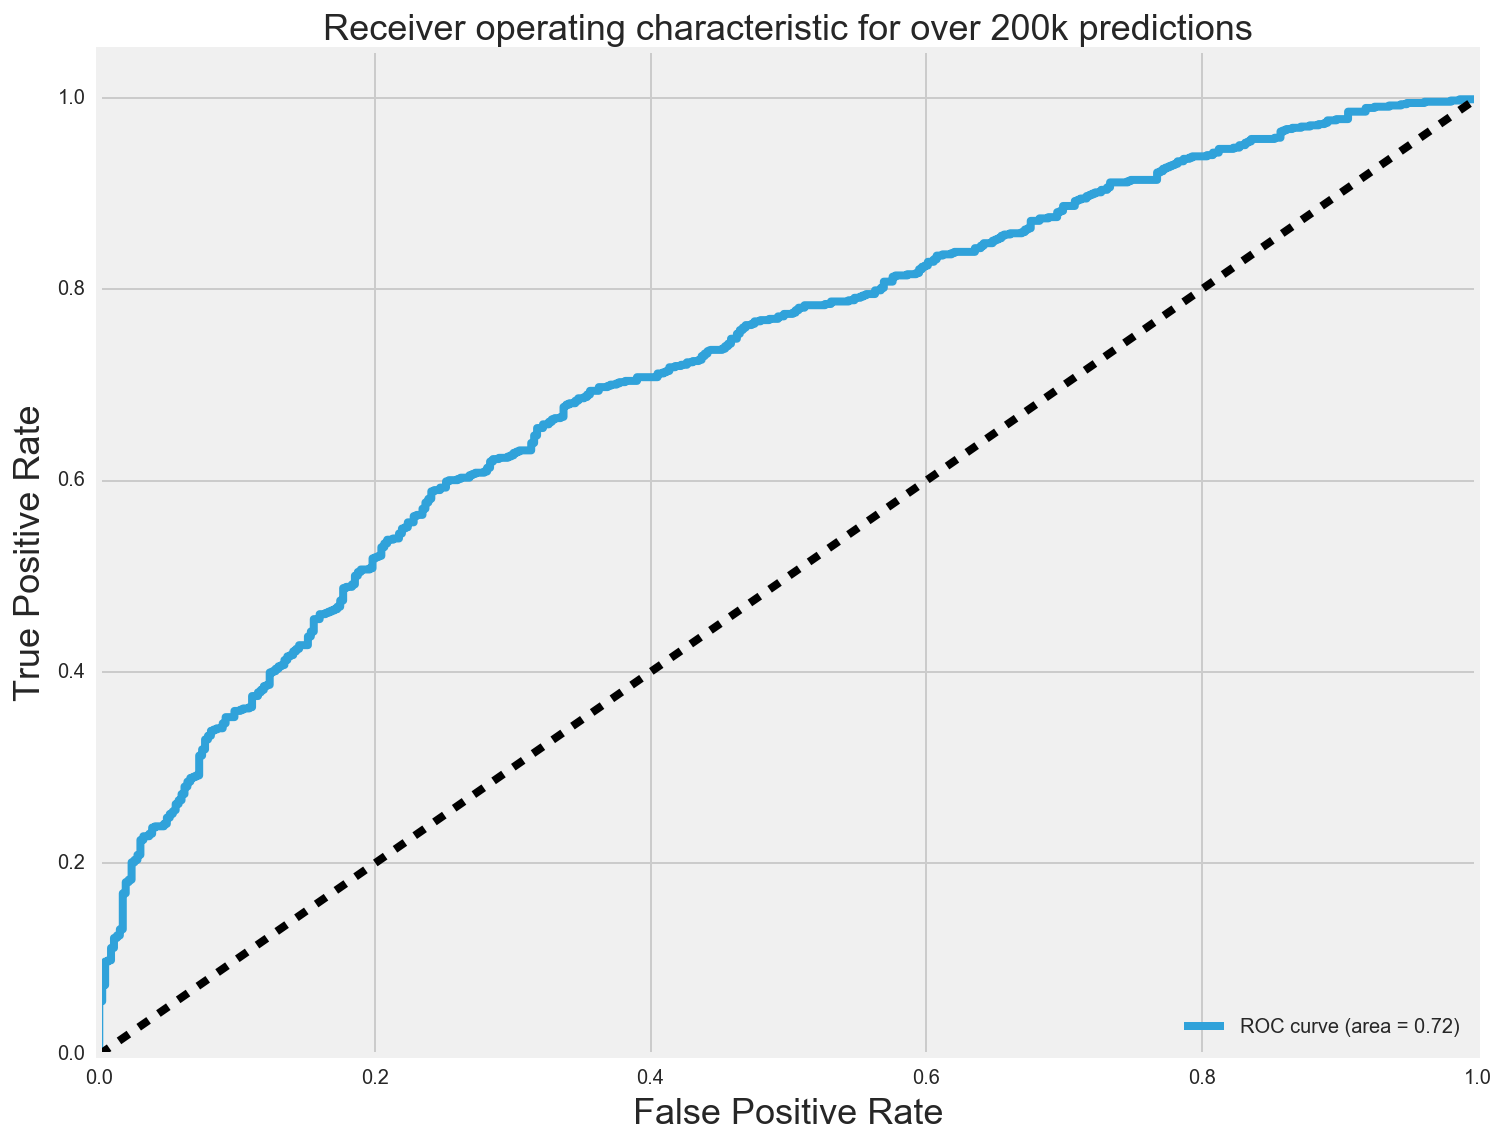

In [37]:
def logistic_regression_calculation(predictors, target, title='Your Prediction'):
    
    ### Test-Train split 70-30
    trainX, testX, trainY, testY = train_test_split(predictors, target, train_size=0.7, stratify=target)
    print 'trainX shape: ', trainX.shape, '\ntestX shape:', testX.shape
    print 'trainY shape: ', trainY.shape, '\ntestY shape:', testY.shape
    
    ### Setup LogisticRegression modeling
    # Create LogisticRegression function cross validated 5 times
    logreg = LogisticRegressionCV(cv=5)
    # Fit the data points into the LogisticRegression model
    model = logreg.fit(trainX, trainY)
    # Predict Probability
    probabilities = model.predict_proba(testX)
    # Score the model
    score = model.score(testX, testY)
    print 'Model Score: ', score
    
    ### Plot the data
    # Creating a blank set of objects to store my confusion matrix metrics here
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # I am assigning the 1st offsets to my FPR / TPR from the 2nd set of probabiliies from my
    # .predict_proba() predictions
    # This data is what will be plotted once we throw it to our figure
    FPR[1], TPR[1], _ = roc_curve(testY, probabilities[:, 1])
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # 1. Initialize a blank plot, aspect 11x9
    plt.figure(figsize=[11,9])
    # 2. Plot my false and true rates (returned from roc_curve function)
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    # 3. Plotting a dotted line diagonally, representing the .5
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for %s' %title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

logistic_regression_calculation(X, y, title='over 200k predictions')



## It's doing a little bit better than random. Next, we're going to add more features from the reviews, tips, and check in dataset

In [442]:
for i in tips.columns:
    print i

user_id
business_id
likes
date
24 hours
amazing food
animal style
awesome food
awesome place
awesome service
beef hash
beer selection
best breakfast
best burger
best burgers
best place
bloody mary
bottle service
carne asada
cheese fries
chicken waffles
come early
cool place
corned beef
customer service
delicious food
don come
don forget
eggs benedict
excellent food
excellent service
fast food
fast service
favorite place
feel like
fish chips
food amazing
food awesome
food drinks
food good
food great
food service
free wifi
french toast
fried chicken
friendly service
friendly staff
gluten free
good food
good place
good service
great atmosphere
great beer
great breakfast
great burgers
great customer
great drinks
great food
great happy
great place
great prices
great service
great spot
great staff
grilled cheese
guest list
happy birthday
happy hour
highly recommend
ice cream
las vegas
late night
live music
long wait
love food
love love
love place
mac cheese
make sure
new favorite
nice place


In [38]:
num_ci = pd.DataFrame((checkin.groupby('business_id')[['value']].sum()))


biz_rev = pd.merge(business5, reviews, how='inner', on = 'business_id')

 
biz_rev_ci = biz_rev.join(num_ci, on = 'business_id')

In [41]:
biz_rev_ci.head(2).T

,0,1
business_id,EmzaQR5hQlF0WIl24NxAZA,EmzaQR5hQlF0WIl24NxAZA
name_x,Sky Lounge,Sky Lounge
review_count,25,25
city,Phoenix,Phoenix
stars_x,2.5,2.5
"(Accepts Credit Cards,)",1,1
"(Accepts Insurance,)",0,0
"(Ages Allowed,)",1,1
"(Alcohol,)",1,1
"(Ambience.casual,)",1,1


In [59]:
biz_rev_ci_n = biz_rev_ci.drop(['business_id', 'name_x', 'city', 'user_id', 'review_id','date' ], axis = 1, inplace=False)

## taking out object columns and time columns

In [47]:
biz_rev_ci.columns[biz_rev_ci.dtypes == 'object']

Index([u'business_id', u'name_x', u'city', u'user_id', u'review_id', u'date'], dtype='object')

In [176]:
biz_rev_ci_n.info()
## Now they are all numerical elements

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322398 entries, 0 to 322397
Columns: 189 entries, review_count to value
dtypes: float64(83), int64(106)
memory usage: 467.3 MB


In [179]:
#deleting the 'las vegas' column
biz_rev_ci_n.drop(['las vegas'], axis =1, inplace= True)

# (3) doing another logistic regression with a combined dataset of reviews, biz, users, and checkins

In [114]:
reviews.isnull().values.any()

False

In [116]:
checkin.isnull().values.any()

False

In [117]:
biz_rev_ci_n.isnull().values.any()
# there are some null values in this dataframe

True

In [118]:
biz_rev_ci_n.select_dtypes(exclude = ['float64', 'int64'])

""
0
1
2
3
4
5
6
7
8
9


In [121]:
# check if there's any infinite values
biz_rev_ci_n.isnull().sum().sum()
#there are 1848 null values

1848

In [125]:
biz_rev_ci_n['value'].isnull().sum().sum()

1848

In [131]:
print biz_rev_ci_n[biz_rev_ci_n['value'].isnull()]['review_count'].mean()
print biz_rev_ci_n['review_count'].mean()
# since those with NaN under 'value' # of check-ins also have very little reviews (comparing to the average of the
# enture 4000 business). 15 VS 673. It makes sense to full in the Nan with 0 assuming that no one check-ed in

15.8154761905
673.221943064


In [132]:
# assuming Nan means no one has checked in in that business
biz_rev_ci_n['value'] = biz_rev_ci_n['value'].fillna(0)

In [180]:
X2 = biz_rev_ci_n.ix[:, biz_rev_ci_n.columns != 'city_num'].values
y2 = biz_rev_ci_n['city_num'].values

print X2.shape, y2.shape

(322398, 187) (322398,)


In [183]:
trainX2, testX2, trainY2, testY2 = train_test_split(X2, y2, train_size=0.7, stratify=y2)
print 'trainX shape: ', trainX2.shape, '\ntestX shape:', testX2.shape
print 'trainY shape: ', trainY2.shape, '\ntestY shape:', testY2.shape

trainX shape:  (225678, 187) 
testX shape: (96720, 187)
trainY shape:  (225678,) 
testY shape: (96720,)


In [184]:
### Setup LogisticRegression modeling
# Create LogisticRegression function cross validated 5 times
logreg = LogisticRegressionCV(cv=5)
# Fit the data points into the LogisticRegression model
model = logreg.fit(trainX2, trainY2)
# Predict Probability
probabilities = model.predict_proba(testX2)
# Score the model
score2 = model.score(testX2, testY2)
print 'Model Score: ', score2

Model Score:  0.797187758478


## Adding extra datasets makes the model performs a lot better. 0.66 VS 0.78 model score now.

trainX shape:  (225678, 188) 
testX shape: (96720, 188)
trainY shape:  (225678,) 
testY shape: (96720,)
Model Score:  0.793320926385


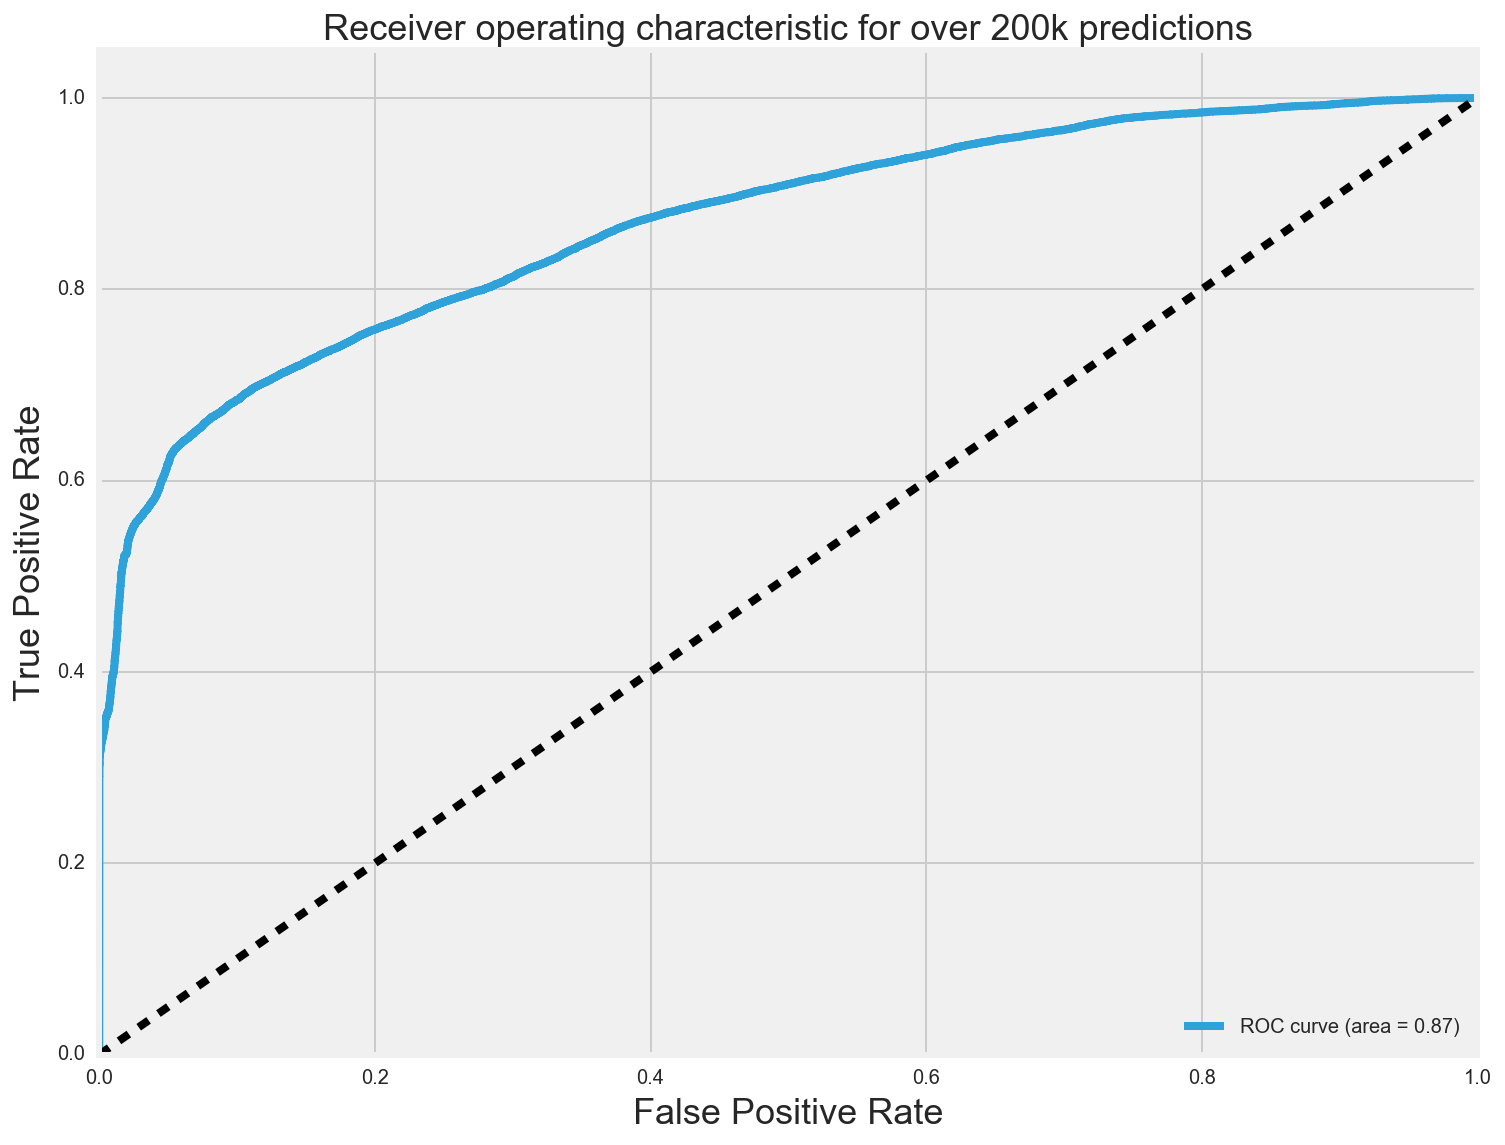

In [136]:
logistic_regression_calculation(X2, y2, title='over 200k predictions')

In [185]:
model.coef_

array([[  2.01542912e-03,  -7.92816198e-03,   2.48344241e-02,
          0.00000000e+00,   2.12190731e-01,  -7.06993085e-01,
          2.82563544e-01,  -1.57042013e-01,   2.13855683e-01,
         -2.73300940e-01,  -1.07147251e-01,  -5.05370384e-02,
          4.84642591e-01,  -9.61553318e-01,   2.41406755e-02,
          9.09588081e-03,   3.53482600e-02,   7.36636389e-02,
          5.23828532e-02,  -4.83620074e-01,   2.76328583e-01,
          4.48308064e-01,   6.19764283e-01,   0.00000000e+00,
         -2.72884087e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -1.25083241e-01,  -2.49606096e-01,
         -7.02751062e-01,   1.55170797e-01,   7.05441583e-01,
          7.42605397e-01,  -5.62592067e-01,   6.28177462e-01,
          2.84299334e-01,  -1.00090141e+00,   4.66165239e-01,
         -3.74296072e-01,   2.91285199e-01,  -1.92372861e-01,
          6.39350234e-02,  -2.25837742e-01,   1.38240748e-01,
          9.52652190e-02,   7.02455066e-02,   1.69959593e-01,
        

In [186]:
tmp_columns = [col for col in biz_rev_ci_n.columns if col != 'city_num']

In [187]:
tmp_columns

['review_count',
 'stars_x',
 ('Accepts Credit Cards',),
 ('Accepts Insurance',),
 ('Ages Allowed',),
 ('Alcohol',),
 ('Ambience.casual',),
 ('Ambience.classy',),
 ('Ambience.divey',),
 ('Ambience.hipster',),
 ('Ambience.intimate',),
 ('Ambience.romantic',),
 ('Ambience.touristy',),
 ('Ambience.trendy',),
 ('Ambience.upscale',),
 ('Attire',),
 ('BYOB',),
 ('BYOB/Corkage',),
 ('By Appointment Only',),
 ('Caters',),
 ('Coat Check',),
 ('Corkage',),
 ('Delivery',),
 ('Dietary Restrictions.dairy-free',),
 ('Dietary Restrictions.gluten-free',),
 ('Dietary Restrictions.halal',),
 ('Dietary Restrictions.kosher',),
 ('Dietary Restrictions.soy-free',),
 ('Dietary Restrictions.vegan',),
 ('Dietary Restrictions.vegetarian',),
 ('Dogs Allowed',),
 ('Drive-Thru',),
 ('Good For Dancing',),
 ('Good For Groups',),
 ('Good For.breakfast',),
 ('Good For.brunch',),
 ('Good For.dessert',),
 ('Good For.dinner',),
 ('Good For.latenight',),
 ('Good For.lunch',),
 ('Good for Kids',),
 ('Happy Hour',),
 ('Has 

In [188]:
feature_importance = pd.DataFrame({'features':tmp_columns, 'coef':model.coef_[0]})

In [189]:
feature_importance.sort_values('coef', ascending=False)

,coef,features
53,1.539712,"(Parking.garage,)"
58,0.746270,"(Price Range,)"
33,0.742605,"(Good For Groups,)"
32,0.705442,"(Good For Dancing,)"
35,0.628177,"(Good For.brunch,)"
22,0.619764,"(Delivery,)"
71,0.535498,new_categories_Bubble Tea
12,0.484643,"(Ambience.touristy,)"
38,0.466165,"(Good For.latenight,)"
21,0.448308,"(Corkage,)"


In [190]:
feature_importance[feature_importance.coef == 0.0]


,coef,features
3,0.0,"(Accepts Insurance,)"
23,0.0,"(Dietary Restrictions.dairy-free,)"
25,0.0,"(Dietary Restrictions.halal,)"
26,0.0,"(Dietary Restrictions.kosher,)"
27,0.0,"(Dietary Restrictions.soy-free,)"


## ^These features don't have any impact on changing the likelihood of predicting Vegas right

In [191]:
prediction_y = model.predict(testX2)

In [192]:
from sklearn.metrics import classification_report
print classification_report(testY2, prediction_y) #making a confusion matrix with actual Y and predict Y

             precision    recall  f1-score   support

          0       0.68      0.53      0.60     27176
          1       0.83      0.90      0.86     69544

avg / total       0.79      0.80      0.79     96720



# Kelly - Report:
- there's a big difference between class 0 and class 1 under support column in the classification report. This is because I turned all non-Vegas to 0 and only Vegas to 1, that's why we got an imbalance problem.
- The weighted average of the precision and recall is 0.86 for identifying Vegas.
- We got a really high recall rate for predicting Vegas which means, given all the predictions, we have accurately predicted Vegas 90% of the time. Meaning that our false negative is really low, we don't usually wrongly predict a bussines that is not in Vegas as Vegas.
- We got a descent precision rate too. Under all the businesses that are in Vegas, we've accurately predicted 83% of them being in Vegas.
- Some key features that are unique about the business in Vegas are that: (1) parkings in a garage, (2) higher price range, (3) good for groups, (4) good for dancing, (5) good for brunch [imagine that Vegas customers wake up late],and (6) offers delivery service.
- Features that identifies a business NOT in Vegas: (1) street parking, (2) good for dinner[?], (3) trendy ambience, (4) outdoor seating, (5) validated parking, (6) offering alcohol, (7) dogs allowed, (8) good for breakfast, (9) take-out service. Keep in mind that the f1_score for identifying non-Vegas is relatively low, 0.6. So that explains why the non-Vegas features seem more random.



In [219]:
business_wide[business_wide['new_value']['attributes.Alcohol'] == 1.0]

business_id                              name  \
variable                                                             
2         -0VK5Z1BfUHUYq4PoBYNLw                            T Spot   
7         -3xbryp44xhpN4BohxXDdQ          The Keg Steakhouse + Bar   
9         -584fn2GxYe9sLsgN2WeQA     Great Links Brewhouse & Grill   
10        -5RN56jH78MV2oquLV_G8g                           Picasso   
11        -68mO1Tk9kVdHsprHFnhnQ                        Le Central   
14        -A5CFmkgdMEggaihtyxX4Q                          nextDOOR   
17        -CIZh4JOZuOEbSzLVrAIGw                Sunrise Casablanca   
19        -DuZnO0oM7uKrRrWX1P60w                    The Maple Tree   
20        -E4VgEmeRZegu1BomYtyQQ  Jeff Civillico: Comedy In Action   
21        -ECyzH2a4YDOYGj3AN54Nw                    Diamond Lounge   
23        -GZsHVDlI6wvLsgD1Yaj0g              The Beat Coffeehouse   
25        -INZ6z5X6RrHdGhk4WoYtg                           Mob Bar   
27        -K22CWorrReIV_kgLa6dmQ                Buffalo Wild Wings   
33        -PESvVv3rPQFAU1_cZ8_hw            Chipotle Mexican Grill   
35        -PyniZNMQuB5u99nr6dYVw                     Bourbon Jacks   
36        -Q-YDKiV5pOLVWoQUFja1g                       Bar Moderno   
37        -QMaaz6TS5DGuxyMg8kxQg                    Outpost Saloon   
38        -RlbIcrNmij2AY8ibiqPsQ                  Andrew Dice Clay   
39        -SB5exmdSotbAFh-NwMmbQ                     Hookah Lounge   
41        -V44Z21fJclQb3NJRe-4dQ                             Rouge   
42        -VnVvJzps8QkDbc1GmHnmQ                       Studio Café   
45        -WZIxGXJHMGidZXRhKxP3w                       Mimi's Cafe   
48        -YeplFvQK1HexxL9D0wCpw                      Zebra Lounge   
50        -_wk7WTa_--ZJWFF_i5v_w          North Central Sports Bar   
54        -gIVoMNqvKWcBpQkpg-10w                     Red House Pub   
55        -gefwOTDqW9HWGDvWBPSMQ                Seamus McCaffrey's   
56        -h-q6zTIdPlkz9BDP11sBg                        Seasons 52   
59        -s9Vc4QS91I4DUfR9V4VgA              Putter's Bar & Grill   
62        -sISgI5JGEvR3K0MSxcXNw                Sean Patrick's Pub   
63        -tD1nntnCk629fx3QgR-vQ          Social Bistro & Wine Bar   
...                          ...                               ...   
4050      yPfvOB63thP5t3pGZPJExA          The Wrigley Mansion Club   
4051      yPpPJyAF8pciHnhTF-C38w                             Homme   
4054      yU07gf7EqYgYEyCyWqRnkA                          The View   
4057      yY5y9PjyPWd-8Pl1XkkBVA                   The Triple Play   
4060      yb17xHvhDJthJGS10uhFeQ                  Ice House Tavern   
4062      yc5AH9H71xJidA_J2mChLA                 Rosie McCaffrey's   
4066      yfzr4CJpDnbMYq91ADc9dQ                              PT's   
4067      yg3te0e_sGmq5EmqZz6pZA                             Eagle   
4068      yggyuN3FV_NiQCKfvN-b-Q  Queen Creek Olive Mill Trattoria   
4073      yo3zehm-cIQLO1mtDsMGXA                       Smashburger   
4079      ywnY2EoUlboGgmXTuczbYQ                              PT's   
4081      yxxLFua918P53BQADGCSCw                    Slice of Vegas   
4083      z-JPAxanvovXIpz9FtD0LQ                        40/40 Club   
4086      z0Wv1bcvKqekMV2svY55jQ                  Blue Hawk Tavern   
4089      z3zcsnK26QhC7TqDX73zvA            Black Angus Steakhouse   
4090      z49aOi7flFdXBXbC58QJvg                         The Local   
4092      z5CwyvKLt88rmWMG-H6MoQ                         Jillian's   
4095      z94yFEohZzipzZPOrJrH6g                   Dave & Buster's   
4096      zAoFrUwRVdSrvYWNB5e5Jw            Taberna Del Tequileria   
4097      zBM9uW6oesXcDhuwCQWSEg                       Sports Deli   
4100      zF2z6b8Hg0Yn7rnxcZGJWw                   Las Vegas Eagle   
4105      zORdAIouXrGO1yU4sIMweg       BJ's Restaurant & Brewhouse   
4115      zgrzP02Hm0ztsxnYvc0FWQ                             B Bar   
4117      ziHNT33d9w56D0C04b3tnw      Charr An American Burger Bar   
4121      zj0BkAi54BGU_AK6AyvJD

In [213]:
business_merge['new_value_attributes.Price Range'].unique()

array([ 1.,  2.,  3.,  0.,  4.])

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


## Kelly: check Elite criterias: https://www.yelp.com/elite

In [286]:
users.head(3)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34


In [279]:
reviews.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [282]:
tips.head()

,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Extend the `LinearRegrssion` class to include the following: 

- Calculate confidence intervals at X% on the $\beta$ coefficients and predicted y value when the model is not regularized. Here is a good overview of calculating confidence intervals: http://imgur.com/a/O1ZFk



- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]

Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the `NearestNeighbor` class such that the fit method doesn't use a `for loop`


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 8. Implement `LogisticRegression` that fits the model using Stochastic Gradient Descent. 

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 9. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [ ]:
# Binary search figures out what the index of a particular item of a array is. 

In [18]:
a = [3,5,6,2,3,5]
b = [11,1,1,1,1]

a.extend(b)
a

[3, 5, 6, 2, 3, 5, 11, 1, 1, 1, 1]

In [54]:
#Implement Merge Sort in Python [Hint: First implement the merge function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of mergesort ?
# input: 2 sorted list
# output: 1 sorted list

def merge(a,b):
    totes = []     
    for i in a:
        for j in b:
            if i<j:
                totes.append(i)
                a = a[i+1:]
            else:
                totes.append(j)
                b= b[j+1:]
    return totes



In [55]:
merge([1,2,3,4],[-1,5,6])


[-1, 1, 1, -1, 2, 2, -1, 3, 3, -1, 4, 4]

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?





P(star)=0.2 per 15 min. 60 min is P(star)=0.8. Assuming they are dependent

Answer: 1- (0.8^4). whereas 0.2^4 gives the probability of seeing at least 4 stars in 1 hour.
0.8 is the probability of not seeing a star in 15 min. So P(not star in 1 hour) = o.8^4. And the opposite of it would be seeing a star in a hour

- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?

1/3

## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 

[bias is over fitting and variance is under fitting. More concretely, bias is when the model you created fits very well in what you think the reality is, but when you put in new data the accuracy will decrease. For example, in your whole life, you've only had yellow mangos. However, when you go to a new planet, their mangos look like a green pinapple but it tastes very similar to what your mango tasted like at home. So your model of what a mango was is a bias because it doesn't match with the reality in another planet.]

[variance means how far your prediction is from the expected output. For example, for someone who doesn't have much experience with dogs. They might just have a general model saying that anything with 4 legs, 2 ears, long nose, big eyes should be a dog. However, there are dogs that look like cat like chihuahua or there are dogs that look like fox. So your model might be able to capture all the dogs, but it will also capture animals that look like dogs but are not.]

[the bias-variance tradeoff means that if you want to decrease bias, you increase variance. If you want to decrease variance, bias increase. If you want to perfectly identify mangos based on their looks, you tried out all the mangos in the world but then you might misidentify green pinapple as mangos. This is an example of trying to decrease bias but increase variance. If you want to eliminate mis-identifying all green pinapples as mangos on Planet A (reduce variance), however your bias will increase meaning that you will not identify a green-piannple-looking mango as a mango anymore.]

[variance : how predictable your model is]. Certain smoothness across your dataset.

[bias : how accurate your model is].  

- Explain why cross-validation is important. 

[you want to make sure that your model is not over-fitting]


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 
